# Run Galfit on HST galaxies
- 11/11/2020: Updated to use galfit_helpers.py module

### Load modules

In [1]:
from __future__ import division
import sys
sys.path.insert(0,'/data/emiln/XLSSC122_GalPops/Analysis/Modules')
from GalfitPyWrap import galfitwrap as gf
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import glob
from scipy import ndimage
from astropy import units as u
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.io import fits, ascii
from astropy.table import Table, hstack, join
import pickle
import fnmatch
import multiprocessing as mp
%matplotlib inline
%load_ext autoreload
%autoreload 2

/data/emiln/miniconda2/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
import galfit_helpers as gfh

### Load HST galaxy catalog


In [20]:
HST_cat_root = '/data/emiln/XLSSC122_GalPops/Data/HST/Products/catalogs/'
HST_cat_filename = HST_cat_root+'xlssc122_F105_F140_redshifts_short_v4_snr_em_member2_by_hand.cat'
full_df, member_df = gfh.load_HST_galaxy_catalog(HST_cat_filename)
# z2_filtered_df = gfh.load_HST_galaxy_catalog(HST_cat_filename,  mag='F140W', magthresh=24, z=2.00, z_thresh=0.1, overwrite=False, verbose=True, goodfit=True) 

In [21]:
member_df.columns.values

array(['phot-id', 'ra', 'dec', 'f105_kron', 'f105_ekron', 'f105_0p8',
       'f105_e0p8', 'f140_kron', 'f140_ekron', 'f140_0p8', 'f140_e0p8',
       'asec_fwhm', 'zz', 'zlo', 'zhi', 'chi', 'spec-id', 'mcode', 'snr',
       'em-code', 'member1', 'member2', 'gold_cluster', 'gold_foreground',
       'silver_cluster', '(f140)kron', 'color', 'F140W', 'ID', 'RA',
       'DEC', 'r_center', 'X', 'Y'], dtype=object)

### Set Galfit parameters

In [34]:
# fit_df = filtered_df[0:4]
fit_df = member_df[0:16]
df_name = 'TEST_modular_galfit'
psf_root = '/data/emiln/XLSSC122_GalPops/Data/HST/Products/PSF/'
# psf_file = psf_root+'cosmos_3dhst.v4.0.F140W_psf.fits' # Filename causes galfit to seg fault
psf_file = psf_root+'3DHST_F140W_PSF.fits'
PSFf = 1 
convbox='64 64'
image_width = 400 # 200 for mag<23 objects, 400 for z2 objects
timeout=5*60
verbose=True
width=10
HLRwidth=5 # Cutout width = 2*HLwidth
PA_INIT = 45
AR_INIT = 0.5
ZP = 26.465 # https://iopscience.iop.org/article/10.1088/0067-0049/214/2/24/pdf page 13
# ZP = 25
# page 20 --> All cataloged fluxes are normalized to AB zero point = 25
MAG_INIT = 21
fitMagnitude = True
neighbourMagThresh=3
DYNMAG = True
sky='Default'
sky_INIT=0.00001
# sigma_file = '/sigma_rms_meanexp_cps.fits'
sigma_file = '/sigma_rms_cps.fits'
data_file = '/data_cps.fits'
constraint_file = 'galfit_constr.txt' # Matches van der wel 2012 constraints
# constr_file = 'none'
badmask='none'
save_name = None

In [35]:
params = {
    'survey':'HST',
    'fit_df':fit_df, # Dataframe with objects to be fit
    'full_df':full_df, # Unfiltered source catalog used for fitting neighbours
    'width':width, # Fitting region width in pixels
    'HLRwidth':HLRwidth, # Fitting region width in # of HLR
    'sigma_file':sigma_file, # Filename of sigma maps for sources
    'data_file':data_file, # Filename for data cutouts for each source
    'PSF_file':psf_file, # File_name of PSF to be used
    'usePSF':True, # Use PSF in fitting?
    'timeout':timeout, # Max runtime per object in seconds
    'PSFf':PSFf, # Fine sampling factor
    'verbose':verbose, # Verbose mode
    'PA_INIT':PA_INIT, # Initial position angle
    'AR_INIT':AR_INIT, # Initial axis ratio
    'MAG_INIT':MAG_INIT, # Initial magnitude
    'convbox':convbox, # Region to convolve PSF with in pixels (i.e. '100 100')
    'ZP':ZP, # Zeropoint 
    'constraint_file':constraint_file, # Galfit constraint filename
    'image_width':image_width, # Size of data+sigma images being used (200 for COSMOS cutouts)
    'useDYNMAG':DYNMAG, # Initialize magnitudes from catalog?
    'badmask':badmask, # filename for bad pixel mask
    'fitMagnitude':fitMagnitude, # Fit magnitudes?
    'sky':sky, # Sky fitting mode for galfit (i.e. 'default')
    'sky_INIT':sky_INIT, # Initial sky level
    'neighbourMagThresh':neighbourMagThresh, # Additional magnitude threshhold to fit neighbours (i.e. 3 -> only neighbours with mag < source_mag+3 are fit)
    'df_name': df_name, # Descriptive name of catalog being fit
    'save_name':save_name # Filename to save results to, overrides default
}

In [36]:
new_df, savename = gfh.run_galfit_parallel(params,**params) # Feeds in unwrapped params as well as a copy to be passed as kwargs to sub functions

e+00]
**** 300 ****
[{'1_RE': '2.4063 +/- 0.0343', '1_N': '3.2081 +/- 0.1370', '1_MAG': '22.3882 +/- 0.0097', '1_YC': '400.8195 +/- 0.0089', '1_XC': '401.2325 +/- 0.0093', '1_PA': '-45.8973 +/- 1.3233', '1_AR': '0.7044 +/- 0.0110', 'COMP_1': 'sersic'}, {'2_YC': '[400.0000]', '2_SKY': '-6.273e-04 +/- 1.147e-04', '2_XC': '[400.0000]', '2_DSDX': '[0.000e+00]', '2_DSDY': '[0.000e+00]', 'COMP_2': 'sky'}]
['2.4063']
['0.0343']
['22.3882']
['0.0097']
['0.7044']
['0.0110']
['-6.273e-04']
['1.147e-04']
***HST***
Initializing 305 with F140W Kron magnitude: 22.52
ID 305
RA: 34.447153
DEC: -3.768007
Initial X: 1422.960813301012
Initial Y: 1643.8586265062913
Cutout X: 400
Cutout Y: 400
Cutout width: 400
Cutoutwidth (pixels) for ID 305 : 54
Cutoutwidth (arcsec) for ID 305 : 3.24
Bounds: [373, 427, 373, 427]
1 NEIGHBOURS FOUND
Adding additional model components for neighbours...
NEIGHBOUR initialized with magnitude: 27.52
Neighbour mag too faint, not being fit
Using PSF
Running galfit from CWD: /data

### Validate results

In [37]:
new_df

,ID,ra,dec,re,ar,n,mag,sky,chi2nu,ErrorValue
0,529,34.434215,-3.758796,19.427300,0.8488,4.6792,20.6667,0.004387,0.790815,0
1,455,34.422282,-3.763513,5.809900,0.8177,2.8275,21.7138,-0.002986,0.509092,0
2,661,34.434096,-3.757658,5.128400,0.8190,3.4535,21.9950,0.004715,0.369403,0
3,1036,34.432450,-3.749924,5.037400,0.4860,3.6866,22.1944,-0.000664,0.307441,0
4,300,34.435031,-3.767948,2.406300,0.7044,3.2081,22.3882,-0.000627,0.320231,0
5,920,34.435628,-3.753143,1.885100,0.7558,10.3458,22.3709,-0.001342,0.350547,16
6,305,34.447153,-3.768007,19.765500,0.4129,9.8615,21.7751,-0.002506,0.276117,0
7,1057,34.436886,-3.750173,3.306400,0.5469,1.6844,22.7495,-0.000327,0.262762,0
8,1065,34.435917,-3.749538,6.321800,0.4291,1.6058,22.3973,0.001183,0.686399,0
9,608,34.438450,-3.760699,0.009298,0.8579,6.4706,22.9337,-0.001989,1.514832,4


In [38]:
new_df

,ID,ra,dec,re,ar,n,mag,sky,chi2nu,ErrorValue
0,529,34.434215,-3.758796,19.427300,0.8488,4.6792,20.6667,0.004387,0.790815,0
1,455,34.422282,-3.763513,5.809900,0.8177,2.8275,21.7138,-0.002986,0.509092,0
2,661,34.434096,-3.757658,5.128400,0.8190,3.4535,21.9950,0.004715,0.369403,0
3,1036,34.432450,-3.749924,5.037400,0.4860,3.6866,22.1944,-0.000664,0.307441,0
4,300,34.435031,-3.767948,2.406300,0.7044,3.2081,22.3882,-0.000627,0.320231,0
5,920,34.435628,-3.753143,1.885100,0.7558,10.3458,22.3709,-0.001342,0.350547,16
6,305,34.447153,-3.768007,19.765500,0.4129,9.8615,21.7751,-0.002506,0.276117,0
7,1057,34.436886,-3.750173,3.306400,0.5469,1.6844,22.7495,-0.000327,0.262762,0
8,1065,34.435917,-3.749538,6.321800,0.4291,1.6058,22.3973,0.001183,0.686399,0
9,608,34.438450,-3.760699,0.009298,0.8579,6.4706,22.9337,-0.001989,1.514832,4


    ID         ra       dec       re      ar       n      mag       sky  \
0  529  34.434215 -3.758796  19.4273  0.8488  4.6792  20.6667  0.004387   

     chi2nu  ErrorValue  
0  0.790815           0  


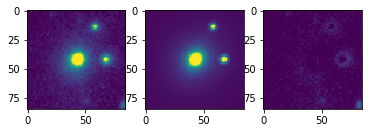

    ID         ra       dec      re      ar       n      mag       sky  \
1  455  34.422282 -3.763513  5.8099  0.8177  2.8275  21.7138 -0.002986   

     chi2nu  ErrorValue  
1  0.509093           0  


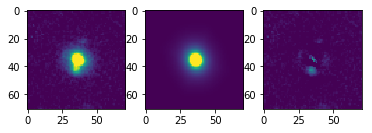

    ID         ra       dec      re     ar       n     mag       sky  \
2  661  34.434096 -3.757658  5.1284  0.819  3.4535  21.995  0.004715   

     chi2nu  ErrorValue  
2  0.369403           0  


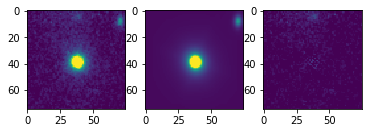

     ID        ra       dec      re     ar       n      mag       sky  \
3  1036  34.43245 -3.749924  5.0374  0.486  3.6866  22.1944 -0.000664   

     chi2nu  ErrorValue  
3  0.307441           0  


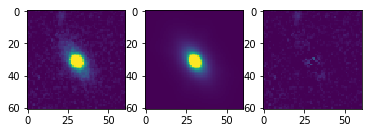

    ID         ra       dec      re      ar       n      mag       sky  \
4  300  34.435031 -3.767948  2.4063  0.7044  3.2081  22.3882 -0.000627   

     chi2nu  ErrorValue  
4  0.320231           0  


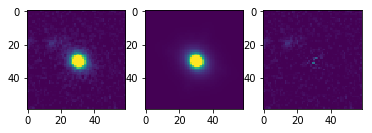

    ID         ra       dec      re      ar        n      mag       sky  \
5  920  34.435628 -3.753143  1.8851  0.7558  10.3458  22.3709 -0.001342   

     chi2nu  ErrorValue  
5  0.350547          16  


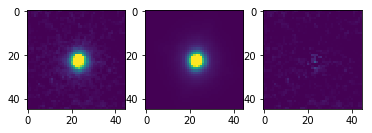

    ID         ra       dec       re      ar       n      mag       sky  \
6  305  34.447153 -3.768007  19.7655  0.4129  9.8615  21.7751 -0.002506   

     chi2nu  ErrorValue  
6  0.276117           0  


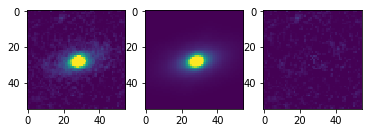

     ID         ra       dec      re      ar       n      mag       sky  \
7  1057  34.436886 -3.750173  3.3064  0.5469  1.6844  22.7495 -0.000327   

     chi2nu  ErrorValue  
7  0.262762           0  


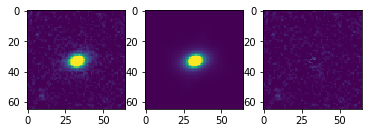

     ID         ra       dec      re      ar       n      mag       sky  \
8  1065  34.435917 -3.749538  6.3218  0.4291  1.6058  22.3973  0.001183   

     chi2nu  ErrorValue  
8  0.686399           0  


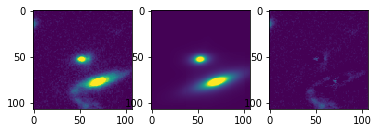

    ID        ra       dec        re      ar       n      mag       sky  \
9  608  34.43845 -3.760699  0.009298  0.8579  6.4706  22.9337 -0.001989   

     chi2nu  ErrorValue  
9  1.514832           4  


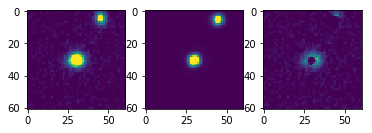

     ID         ra       dec      re      ar       n      mag       sky  \
10  243  34.422417 -3.770003  2.4173  0.6146  2.5087  22.4893 -0.001996   

      chi2nu  ErrorValue  
10  0.300822           0  


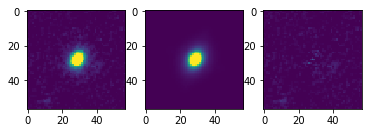

     ID         ra       dec        re      ar       n      mag       sky  \
11  644  34.433802 -3.758806  0.009999  0.7685  3.6148  23.4552  0.003472   

      chi2nu  ErrorValue  
11  0.836266           4  


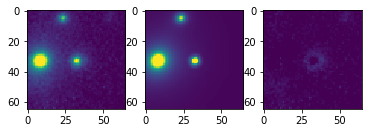

     ID         ra       dec      re     ar       n      mag       sky  \
12  847  34.434697 -3.754887  1.9923  0.822  2.9938  23.2683  0.000302   

      chi2nu  ErrorValue  
12  0.269025           0  


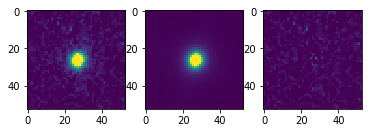

     ID         ra       dec      re      ar       n      mag       sky  \
13  375  34.444096 -3.765667  6.5533  0.8278  3.6733  22.7263 -0.001401   

      chi2nu  ErrorValue  
13  0.258372           0  


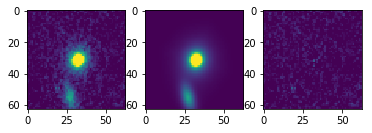

     ID         ra       dec      re      ar       n      mag       sky  \
14  735  34.425011 -3.758034  2.5573  0.4993  2.3223  23.2428 -0.001384   

      chi2nu  ErrorValue  
14  0.275553           0  


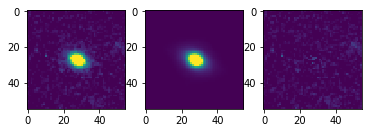

      ID         ra       dec      re      ar       n      mag       sky  \
15  1223  34.443347 -3.745001  1.3646  0.7806  1.9784  23.3876  0.000092   

      chi2nu  ErrorValue  
15  0.299401           0  


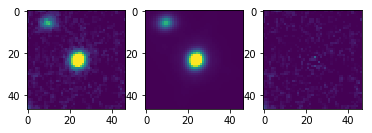

In [39]:
# Plot fits by ID
for ID in fit_df['ID']:
    gfh.plot_by_ID(ID,save_name=savename,survey='HST')